# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

### Business Understanding - Response:

We frame “what drives used-car prices?” as a supervised regression problem where the target is price (USD) and predictors include vehicle attributes (e.g., year, odometer, condition, fuel, drive, transmission, type, cylinders, title_status, state, etc.). We will build interpretable linear models (OLS, Ridge, Lasso, ElasticNet) with a preprocessing pipeline that handles missing values, outliers (price winsorized), feature engineering (car_age), and one-hot encoding for categorical variables. Model quality will be assessed via K-fold cross-validation using MAE as the primary metric (with RMSE and R² reported). Success is defined as a clear, ranked list of price drivers (direction + relative magnitude) and a ≥20% MAE improvement over a naive baseline (predicting the median price), translated into practical stocking and pricing recommendations for dealers.

In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

RANDOM_SEED = 42
CURRENT_YEAR = 2025

sns.set(style="whitegrid")
pd.set_option("display.max_columns", 120)


# Modeling imports
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Warning imports
import warnings
from sklearn.exceptions import ConvergenceWarning


### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

### Data Understanding - Response:

### Objective
Audit data quality and learn which fields relate to `price` so we can design sensible cleaning and features for regression.

### 1) What I inspected

1. **Snapshot & schema** – `head()`, `info(show_counts=True)`, `describe()` to confirm row/column counts, dtypes, and anomalies.
2. **Missingness** – percent missing by column and notable patterns.
3. **Validity checks** – `price > 0`, plausible `year` (≥1960), plausible `odometer` (0–500k).
4. **Target distribution** – histogram of `price` and `log1p(price)` for skew.
5. **Duplicates & leakage** – duplicates on `id`/`VIN`; scan for leakage cols; inspect repeat VINs for differing values.
6. **Cardinality** – `nunique` for categoricals to flag high-cardinality fields (e.g., `model`).
7. **Univariate & bivariate signals**
   - Numeric → price: scatter + trend for `year`, `car_age`, `odometer`.
   - Categorical → price: box/violin/median bars for top levels of `manufacturer`, `condition`, `fuel`, `drive`, `transmission`, `type`, `title_status`, `paint_color`, `state`.
8. **Correlation among numerics** – heatmap to spot multicollinearity.
9. **Optional EDA (insight only)** – PCA on standardized numerics and k-means clusters for visualization (not used in modeling unless inside the pipeline).

### 2) What I found (fill as you review)

- **Size & schema:** rows = `426,880`, cols = `18`; target = `price` (numeric).
- **Missingness:** high in `size`; moderate in `cylinders, condition, VIN, drive, paint_color, type`.
- **Target shape:** `price` is right-skewed; `log1p(price)` looks more symmetric.
- **Validity issues:** non-positive prices; out-of-range `year`/`odometer`.
- **Duplicates/leakage:** `id` unique (0); `VIN`repeated (308,633 rows ≈ 72%); no URL/image/GPS cols → dedupe by normalized VIN and drop `id`/`VIN` from features.
- **High-cardinality categoricals:** `model (~29.6k)`, `region (404)` → collapse rare levels to `__other__` (e.g., keep top-N or levels with ≥ 200 rows). `VIN` is an identifier (118k) → drop/dedupe, not modeled.
- **Early signals (direction):** newer **year** / lower **car_age** ↑ price; lower **odometer** ↑ price; **clean** title/condition ↑ price; **salvage/rebuilt** ↓ price; segment effects for **drive/type/transmission/fuel**.

In [11]:
# DU-01: Load vehicles.csv from fixed path
DATA_PATH = "data/vehicles.csv"

raw_df = pd.read_csv(DATA_PATH, low_memory=False)
print(f"Loaded {DATA_PATH} | rows={len(raw_df):,}  cols={raw_df.shape[1]}")
raw_df.head(10)  # quick peek only


Loaded data/vehicles.csv | rows=426,880  cols=18


,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc
5,7222379453,hudson valley,1600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ny
6,7221952215,hudson valley,1000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ny
7,7220195662,hudson valley,15995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ny
8,7209064557,medford-ashland,5000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,or
9,7219485069,erie,3000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,pa


In [12]:
# DU-02: Schema snapshot + basic stats (concise)
schema = pd.DataFrame({
    "dtype": raw_df.dtypes,
    "non_null": raw_df.notna().sum(),
    "missing_pct": raw_df.isna().mean().round(3)
}).sort_index()
display(schema)

# Numeric summary (transpose for readability)
desc_num = raw_df.describe(percentiles=[.01, .05, .50, .95, .99]).T.round(2)
display(desc_num.head(15))

# Categorical snapshot
desc_cat = raw_df.select_dtypes("object").describe().T
display(desc_cat[["count", "unique", "top", "freq"]].head(15))


,dtype,non_null,missing_pct
VIN,object,265838,0.377
condition,object,252776,0.408
cylinders,object,249202,0.416
drive,object,296313,0.306
fuel,object,423867,0.007
id,int64,426880,0.000
manufacturer,object,409234,0.041
model,object,421603,0.012
odometer,float64,422480,0.010
paint_color,object,296677,0.305


,count,mean,std,min,1%,5%,50%,95%,99%,max
id,426880.0,7.311487e+09,4473170.41,7.207408e+09,7.301962e+09,7.303150e+09,7.312621e+09,7.316743e+09,7.316956e+09,7.317101e+09
price,426880.0,7.519903e+04,12182282.17,0.000000e+00,0.000000e+00,0.000000e+00,1.395000e+04,4.450000e+04,6.699500e+04,3.736929e+09
year,425675.0,2.011240e+03,9.45,1.900000e+03,1.967000e+03,1.998000e+03,2.013000e+03,2.020000e+03,2.020000e+03,2.022000e+03
odometer,422480.0,9.804333e+04,213881.50,0.000000e+00,2.000000e+00,6.318000e+03,8.554800e+04,2.040000e+05,2.800000e+05,1.000000e+07


,count,unique,top,freq
region,426880,404,columbus,3608
manufacturer,409234,42,ford,70985
model,421603,29649,f-150,8009
condition,252776,6,good,121456
cylinders,249202,8,6 cylinders,94169
fuel,423867,5,gas,356209
title_status,418638,6,clean,405117
transmission,424324,3,automatic,336524
VIN,265838,118246,1FMJU1JT1HEA52352,261
drive,296313,3,4wd,131904


In [13]:
# DU-03: EDA copy + light type coercion + helper features (robust)

# Make an EDA-only copy so we don't mutate raw_df
eda_df = raw_df.copy()

# Coerce key numeric fields
for col in ("price", "year", "odometer"):
    if col in eda_df.columns:
        eda_df[col] = pd.to_numeric(eda_df[col], errors="coerce")

# Helper feature: car_age (if year exists)
if "year" in eda_df.columns:
    # Use the constant from DU-00 if defined, else default
    try:
        CURRENT_YEAR
    except NameError:
        CURRENT_YEAR = 2025
    eda_df["car_age"] = CURRENT_YEAR - eda_df["year"]

# Optional text length feature if a description-like column exists
desc_col = next((c for c in ["description", "desc", "text"] if c in eda_df.columns), None)
if desc_col is not None:
    eda_df["desc_len"] = eda_df[desc_col].astype(str).str.len()

# Preview only the columns that are present (avoids KeyErrors)
preview_cols = [c for c in ["price", "year", "odometer", "car_age", "desc_len"] if c in eda_df.columns]
display(eda_df[preview_cols].head())


,price,year,odometer,car_age
0,6000,NaN,NaN,NaN
1,11900,NaN,NaN,NaN
2,21000,NaN,NaN,NaN
3,1500,NaN,NaN,NaN
4,4900,NaN,NaN,NaN


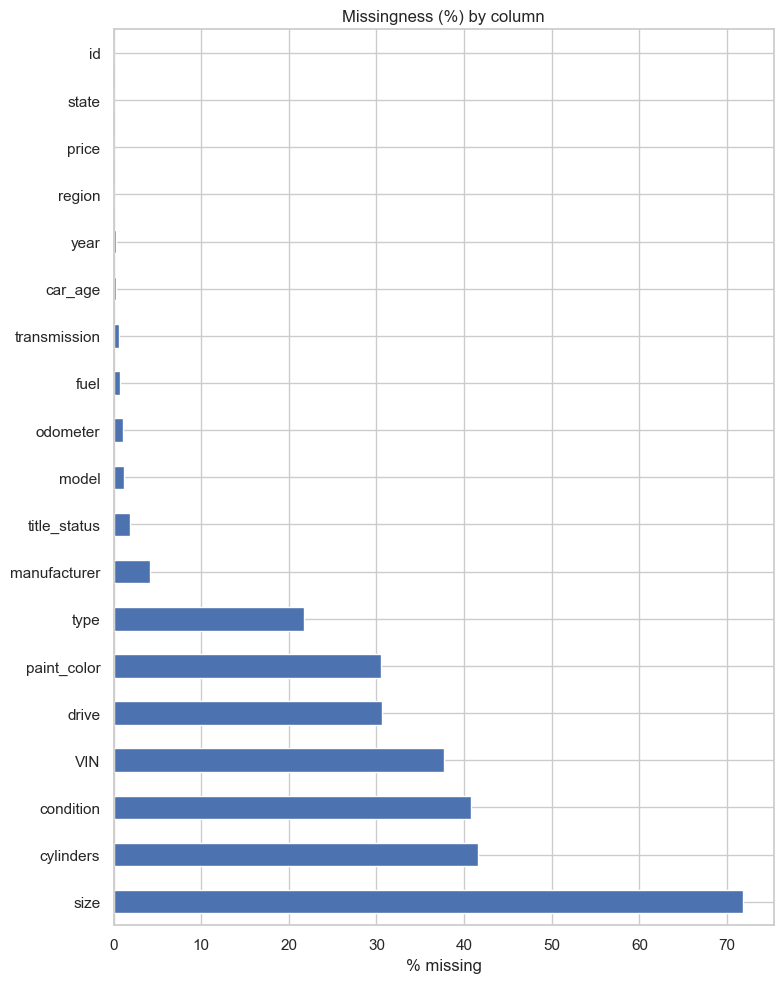

,missing_pct
size,0.718
cylinders,0.416
condition,0.408
VIN,0.377
drive,0.306
paint_color,0.305
type,0.218
manufacturer,0.041
title_status,0.019
model,0.012


In [14]:
# DU-04: Missingness by column
missing_pct = eda_df.isna().mean().sort_values(ascending=False)

plt.figure(figsize=(8, 10))
(missing_pct * 100).plot(kind="barh")
plt.title("Missingness (%) by column")
plt.xlabel("% missing"); plt.tight_layout(); plt.show()

missing_pct.head(20).to_frame("missing_pct").round(3)


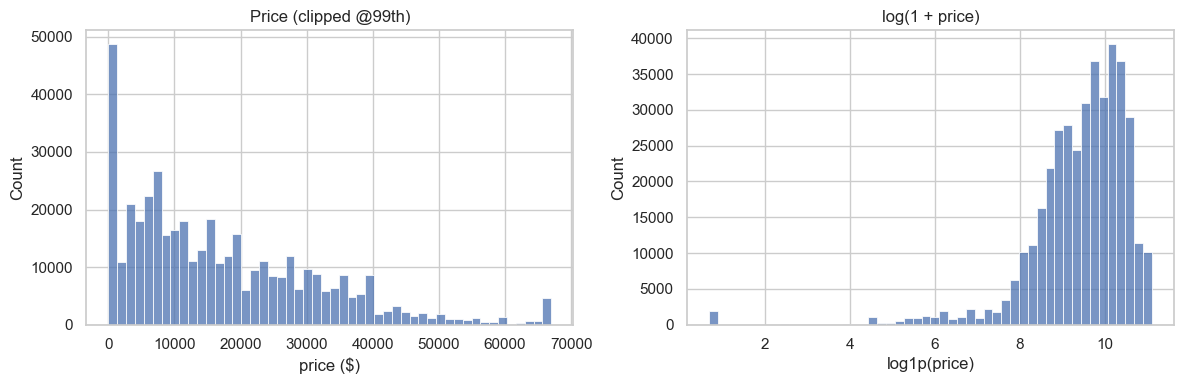

,price_stats
count,4.268800e+05
mean,7.519903e+04
std,1.218228e+07
min,0.000000e+00
1%,0.000000e+00
5%,0.000000e+00
50%,1.395000e+04
95%,4.450000e+04
99%,6.699500e+04
max,3.736929e+09


In [15]:
# DU-05: Target distribution (price)
price_ser = eda_df["price"].dropna()

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(price_ser.clip(upper=price_ser.quantile(0.99)), bins=50, ax=ax[0])
ax[0].set_title("Price (clipped @99th)"); ax[0].set_xlabel("price ($)")

pos = price_ser[price_ser > 0].clip(upper=price_ser.quantile(0.99))
sns.histplot(np.log1p(pos), bins=50, ax=ax[1])
ax[1].set_title("log(1 + price)"); ax[1].set_xlabel("log1p(price)")
plt.tight_layout(); plt.show()

price_ser.describe(percentiles=[.01,.05,.50,.95,.99]).to_frame("price_stats").round(2)


In [16]:
# DU-06: Duplicates and potential leakage columns
for key in ("id", "VIN", "url"):
    if key in eda_df.columns:
        dup_count = eda_df.duplicated(subset=[key]).sum()
        print(f"Duplicates by {key}: {dup_count:,}")

leakage_cols = [c for c in ["id","url","region_url","image_url","VIN",
                            "description","county","lat","long","posting_date"]
                if c in eda_df.columns]
print("Potential leakage / non-predictive columns:", leakage_cols)


Duplicates by id: 0
Duplicates by VIN: 308,633
Potential leakage / non-predictive columns: ['id', 'VIN']


In [17]:
# DU-07: Cardinality of categorical variables
nunique = eda_df.nunique(dropna=True).sort_values(ascending=False)
display(nunique.head(20))

high_card_cats = [c for c in eda_df.select_dtypes("object").columns
                  if eda_df[c].nunique(dropna=True) > 100]
print("High-cardinality categoricals (consider collapsing rare levels):", high_card_cats[:15])


id              426880
VIN             118246
odometer        104870
model            29649
price            15655
region             404
year               114
car_age            114
state               51
manufacturer        42
type                13
paint_color         12
cylinders            8
condition            6
title_status         6
fuel                 5
size                 4
transmission         3
drive                3
dtype: int64

High-cardinality categoricals (consider collapsing rare levels): ['region', 'model', 'VIN']


In [18]:
# DU-08 (revised): Duplicate analysis focused on VIN

def normalize_vin(s):
    return (s.astype(str)
             .str.upper()
             .str.replace(r"[^A-Z0-9]", "", regex=True)
             .str.strip()
             .replace({"": np.nan}))

dup_df = eda_df.copy()
if "VIN" in dup_df.columns:
    dup_df["VIN_norm"] = normalize_vin(dup_df["VIN"])
    
    # How many rows have a VIN? How many are duplicates among those?
    has_vin = dup_df["VIN_norm"].notna()
    n_with_vin = has_vin.sum()
    n_dups_vin = dup_df.loc[has_vin, "VIN_norm"].duplicated(keep="first").sum()
    print(f"Rows with VIN: {n_with_vin:,}")
    print(f"Duplicates among rows WITH VIN: {n_dups_vin:,} "
          f"({n_dups_vin / len(dup_df):.1%} of all rows)")
    
    # Group size distribution for repeated VINs
    grp_sizes = dup_df.loc[has_vin].groupby("VIN_norm").size()
    rep = grp_sizes[grp_sizes > 1].sort_values(ascending=False)
    display(rep.describe().round(2))  # how many repeats per VIN
    
    # Are repeats exact copies or do key fields differ?
    key_vars = [c for c in ["year","odometer","price","model","manufacturer"] if c in dup_df.columns]
    if key_vars:
        diffs = (dup_df.loc[has_vin, ["VIN_norm"] + key_vars]
                       .drop_duplicates()
                       .groupby("VIN_norm").size())
        # diffs > 1 means same VIN appears with differing values
        print("VINs with differing key values:", int((diffs > 1).sum()))
else:
    print("VIN column not present; nothing to analyze.")


Rows with VIN: 426,880
Duplicates among rows WITH VIN: 308,633 (72.3% of all rows)


count     40281.00
mean          8.66
std         802.41
min           2.00
25%           2.00
50%           3.00
75%           4.00
max      161042.00
dtype: float64

VINs with differing key values: 5990


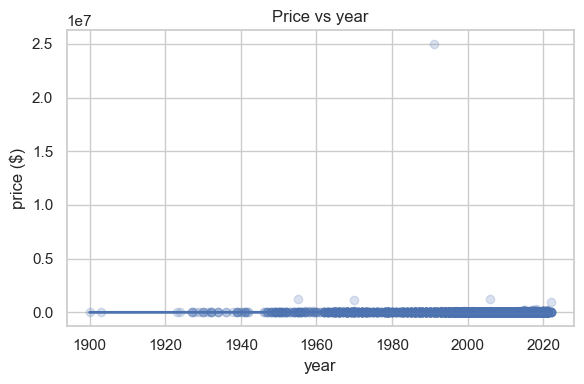

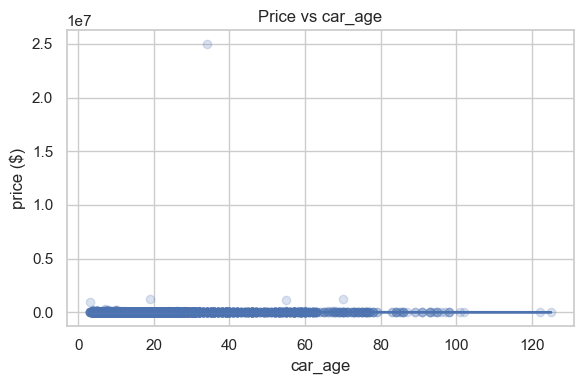

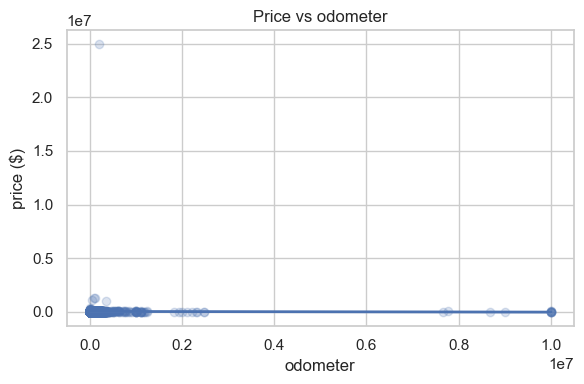

In [19]:
# DU-09: Numeric → price relationships (sampled for speed)
sample_df = eda_df.sample(n=min(20_000, len(eda_df)), random_state=RANDOM_SEED)
NUM_CANDIDATES = ["year", "car_age", "odometer"]
num_cols = [c for c in NUM_CANDIDATES if c in sample_df.columns]

for col in num_cols:
    plt.figure(figsize=(6, 4))
    sns.regplot(data=sample_df, x=col, y="price",
                scatter_kws={"alpha":0.2}, line_kws={"lw":2})
    plt.title(f"Price vs {col}")
    plt.xlabel(col); plt.ylabel("price ($)")
    plt.tight_layout(); plt.show()


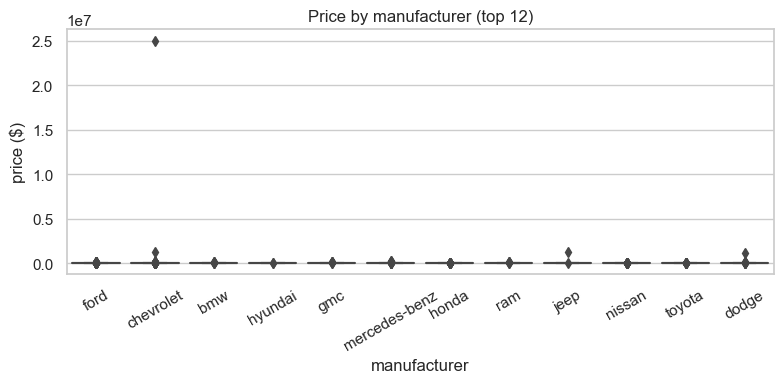

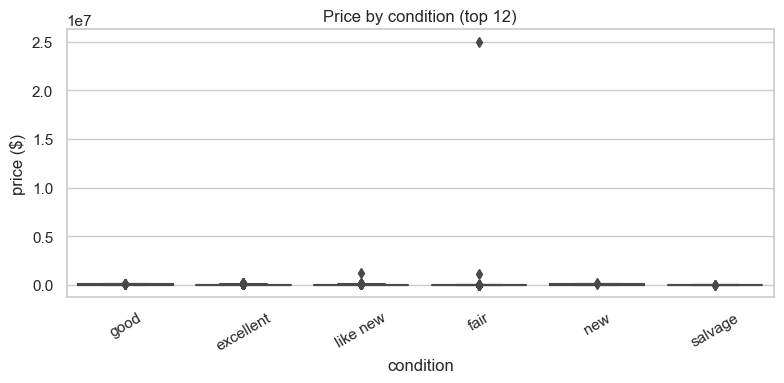

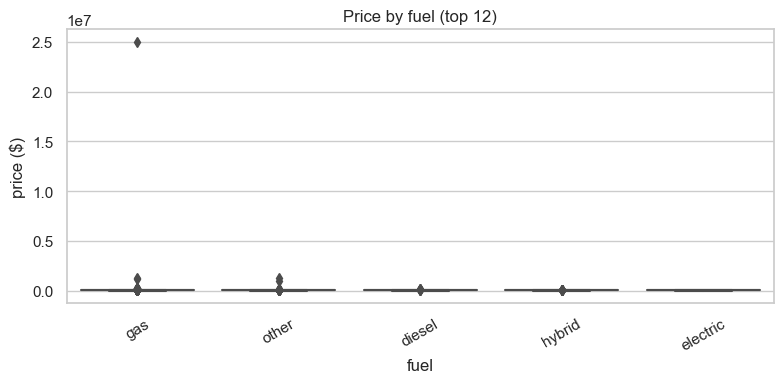

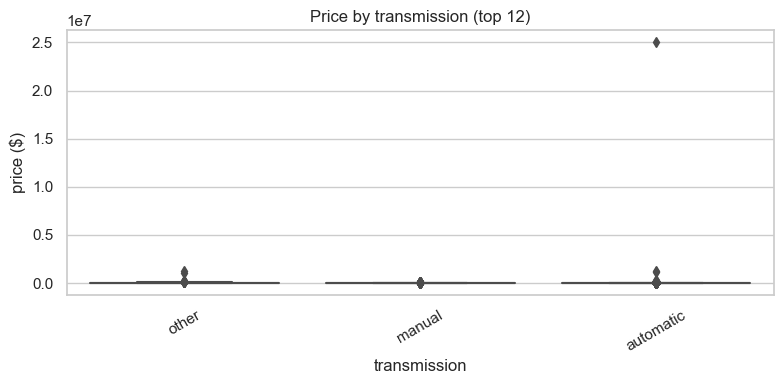

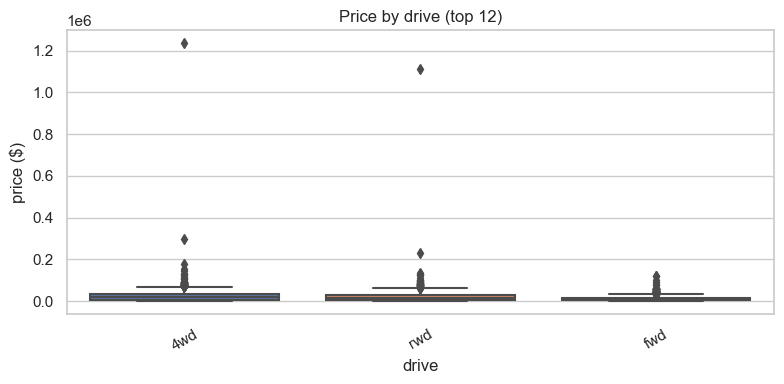

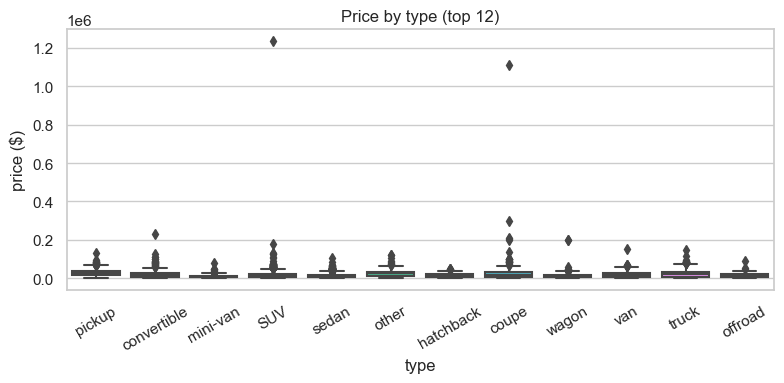

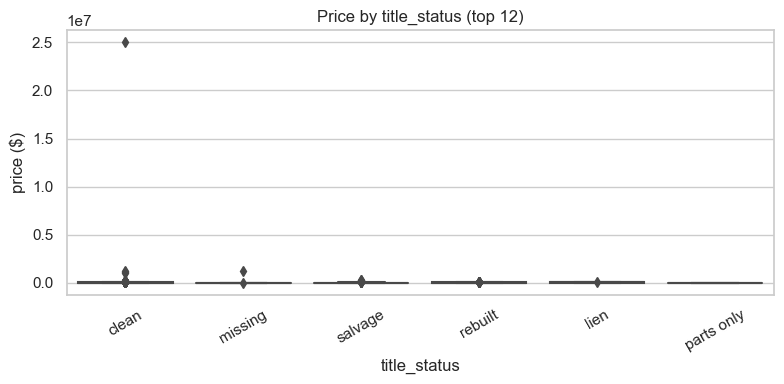

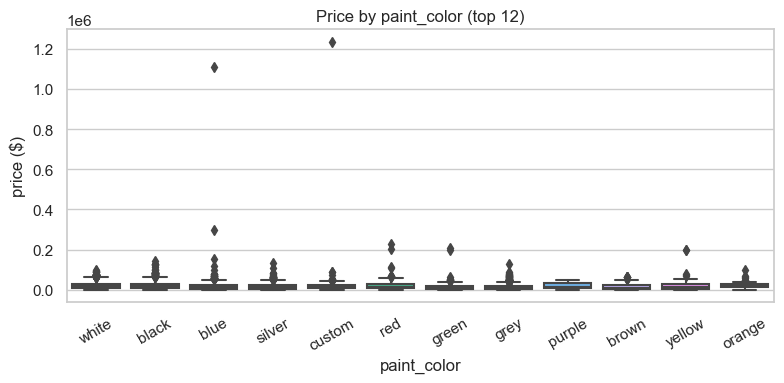

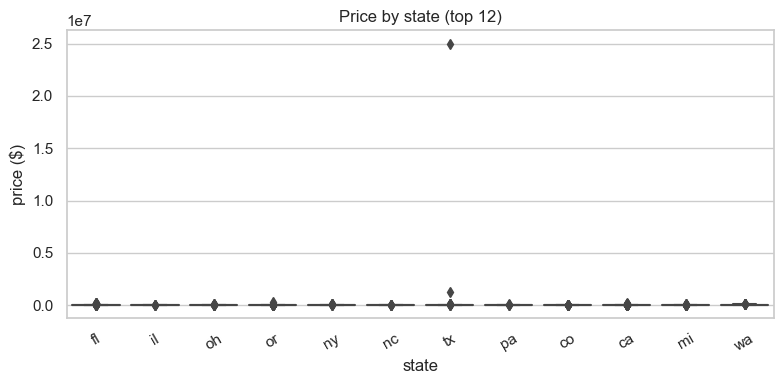

In [20]:
# DU-10: Categorical → price (top 12 levels only)
CAT_CANDIDATES = ["manufacturer","condition","fuel","transmission","drive",
                  "type","title_status","paint_color","state"]
cat_cols = [c for c in CAT_CANDIDATES if c in sample_df.columns]

for col in cat_cols:
    top_levels = sample_df[col].value_counts().head(12).index
    plt.figure(figsize=(8, 4))
    sns.boxplot(data=sample_df[sample_df[col].isin(top_levels)], x=col, y="price")
    plt.title(f"Price by {col} (top 12)"); plt.xlabel(col); plt.ylabel("price ($)")
    plt.xticks(rotation=30)
    plt.tight_layout(); plt.show()


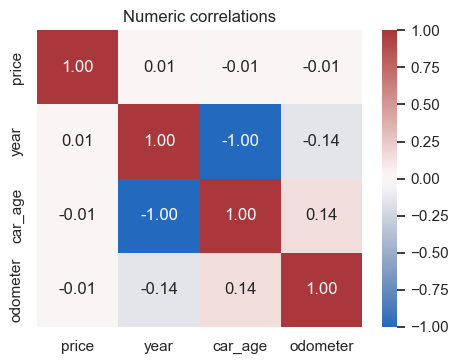

In [21]:
# DU-11: Correlation among numeric features (version-robust)

corr_cols = [c for c in ["price", "year", "car_age", "odometer", "desc_len"]
             if c in sample_df.columns]

# Ensure numeric dtype & allow NaNs (pairwise complete obs)
num_df = sample_df[corr_cols].apply(pd.to_numeric, errors="coerce")

if num_df.shape[1] >= 2:
    corr = num_df.corr(method="pearson")  # or method="spearman" if you prefer rank corr
    plt.figure(figsize=(4.8, 3.8))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="vlag", center=0, vmin=-1, vmax=1)
    plt.title("Numeric correlations")
    plt.tight_layout(); plt.show()
    corr
else:
    print("Not enough numeric columns for a correlation matrix.")


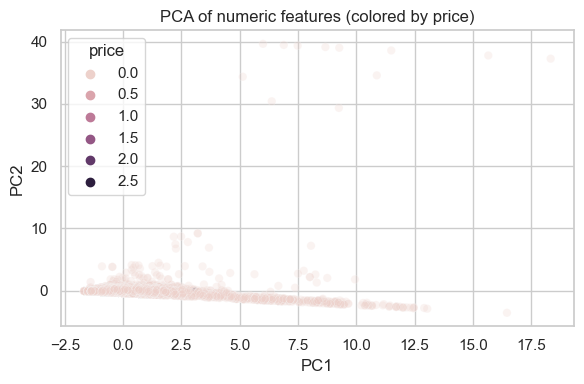

In [22]:
# DU-12 (optional): PCA on standardized numeric features (EDA only)

pca_cols = [c for c in ["year","car_age","odometer"] if c in sample_df.columns]
if len(pca_cols) >= 2:
    Z = sample_df[pca_cols].dropna()
    Zs = StandardScaler().fit_transform(Z)
    PCs = PCA(n_components=2).fit_transform(Zs)
    pca_df = pd.DataFrame(PCs, columns=["PC1","PC2"], index=Z.index)
    pca_df["price"] = sample_df.loc[Z.index, "price"]
    plt.figure(figsize=(6, 4))
    sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="price", alpha=0.25)
    plt.title("PCA of numeric features (colored by price)")
    plt.tight_layout(); plt.show()
else:
    print("PCA skipped (need at least two numeric columns).")


In [23]:
# DU-13: Auto-summary for the "What I found" markdown

# 1) Size & schema
n_rows, n_cols = raw_df.shape

# 2) Missingness (top)
missing = raw_df.isna().mean().sort_values(ascending=False)
missing_top = (missing[missing > 0]
               .head(10)
               .mul(100).round(1)
               .astype(str) + "%")

# 3) Target shape/stats
price = pd.to_numeric(raw_df.get("price"), errors="coerce")
price_stats = price.describe(percentiles=[.01,.05,.50,.95,.99]).round(2)

# 4) Validity sanity checks
year = pd.to_numeric(raw_df.get("year"), errors="coerce")
odom = pd.to_numeric(raw_df.get("odometer"), errors="coerce")
yr_bad = int(((year < 1960) | (year > CURRENT_YEAR)).sum()) if "year" in raw_df else 0
od_bad = int(((odom < 0) | (odom > 500_000)).sum()) if "odometer" in raw_df else 0
nonpos_price = int((price.notna() & (price <= 0)).sum())

# 5) Duplicates by common IDs
dups = {}
for key in ("id","VIN","url"):
    if key in raw_df.columns:
        dups[key] = int(raw_df.duplicated(subset=[key]).sum())

# 6) High-cardinality categoricals (threshold = 100 unique)
high_card = []
for c in raw_df.select_dtypes("object").columns:
    u = raw_df[c].nunique(dropna=True)
    if u > 100:
        high_card.append((c, u))
high_card = sorted(high_card, key=lambda x: x[1], reverse=True)[:10]

print("— Size & schema —")
print(f"rows = {n_rows:,}, cols = {n_cols}")
print("\n— Top missingness —")
print(pd.Series(missing_top))
print("\n— Target (price) stats —")
print(price_stats)
print("\n— Validity issues (counts) —")
print({"non_positive_price": nonpos_price, "year_out_of_range": yr_bad, "odometer_out_of_range": od_bad})
print("\n— Duplicates by ID —")
print(dups or "No ID columns present.")
print("\n— High-cardinality categoricals (>100 unique) —")
print(high_card)


— Size & schema —
rows = 426,880, cols = 18

— Top missingness —
size            71.8%
cylinders       41.6%
condition       40.8%
VIN             37.7%
drive           30.6%
paint_color     30.5%
type            21.8%
manufacturer     4.1%
title_status     1.9%
model            1.2%
dtype: object

— Target (price) stats —
count    4.268800e+05
mean     7.519903e+04
std      1.218228e+07
min      0.000000e+00
1%       0.000000e+00
5%       0.000000e+00
50%      1.395000e+04
95%      4.450000e+04
99%      6.699500e+04
max      3.736929e+09
Name: price, dtype: float64

— Validity issues (counts) —
{'non_positive_price': 32895, 'year_out_of_range': 2458, 'odometer_out_of_range': 1386}

— Duplicates by ID —
{'id': 0, 'VIN': 308633}

— High-cardinality categoricals (>100 unique) —
[('VIN', 118246), ('model', 29649), ('region', 404)]


### Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [25]:
# DP-01: Clean + dedupe + engineer features

CURRENT_YEAR = CURRENT_YEAR

def normalize_vin(s):
    return (s.astype(str).str.upper()
            .str.replace(r"[^A-Z0-9]", "", regex=True)
            .str.strip()
            .replace({"": np.nan}))

def clean_and_engineer(df_raw,
                       current_year=CURRENT_YEAR,
                       price_q_lo=0.01, price_q_hi=0.99):
    df = df_raw.copy()

    # types
    for c in ("price","year","odometer"):
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    # dedupe by VIN (keep first), keep rows with no VIN
    before = len(df)
    if "VIN" in df.columns:
        df["VIN_norm"] = normalize_vin(df["VIN"])
        has_vin = df["VIN_norm"].notna()
        df = pd.concat([
            df.loc[~has_vin],
            df.loc[has_vin].drop_duplicates(subset=["VIN_norm"], keep="first")
        ], ignore_index=True)
        df.drop(columns=["VIN_norm"], inplace=True)

    # target validity + winsorize target to tame extreme listings
    df = df[df["price"].notna() & (df["price"] > 0)]
    lo, hi = df["price"].quantile([price_q_lo, price_q_hi])
    df = df[(df["price"] >= lo) & (df["price"] <= hi)]

    # reasonable ranges
    if "year" in df.columns:
        df = df[(df["year"].between(1960, current_year)) | df["year"].isna()]
        df["car_age"] = current_year - df["year"]
    if "odometer" in df.columns:
        df = df[(df["odometer"].between(0, 500_000)) | df["odometer"].isna()]

    # optional text feature if present
    if "description" in df.columns:
        df["desc_len"] = df["description"].astype(str).str.len()

    # drop identifiers / blobs
    drop_cols = ["id","VIN","url","region_url","image_url","description",
                 "county","lat","long","posting_date"]
    df = df.drop(columns=[c for c in drop_cols if c in df.columns], errors="ignore")

    # normalize string categoricals
    for c in df.select_dtypes("object").columns:
        df[c] = df[c].str.strip().str.lower()

    print(f"Cleaned: {before:,} → {len(df):,} rows")
    return df

df_clean = clean_and_engineer(raw_df)
df_clean.head()


Cleaned: 426,880 → 103,185 rows


,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state,car_age
0,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az,NaN
1,auburn,33590,2014.0,gmc,sierra 1500 crew cab slt,good,8 cylinders,gas,57923.0,clean,other,NaN,NaN,pickup,white,al,11.0
2,auburn,22590,2010.0,chevrolet,silverado 1500,good,8 cylinders,gas,71229.0,clean,other,NaN,NaN,pickup,blue,al,15.0
3,auburn,39590,2020.0,chevrolet,silverado 1500 crew,good,8 cylinders,gas,19160.0,clean,other,NaN,NaN,pickup,red,al,5.0
4,auburn,30990,2017.0,toyota,tundra double cab sr,good,8 cylinders,gas,41124.0,clean,other,NaN,NaN,pickup,red,al,8.0


In [26]:
# DP-02: Collapse rare categories for high-card columns
def collapse_rare(series: pd.Series, min_count=200):
    vc = series.value_counts(dropna=True)
    keep = set(vc[vc >= min_count].index)
    return series.where(series.isin(keep), "__other__")

RARE_MIN = 200

# Only collapse if column exists
for col in ["model", "region"]:
    if col in df_clean.columns:
        df_clean[col] = collapse_rare(df_clean[col], min_count=RARE_MIN)

# Quick check
for col in [c for c in ["model","region"] if c in df_clean.columns]:
    vc = df_clean[col].value_counts(dropna=False)
    print(f"{col}: kept={ (vc >= RARE_MIN).sum() }  total_levels={ len(vc) }")


model: kept=86  total_levels=86
region: kept=143  total_levels=143


In [27]:
# DP-03: Feature lists (cats/nums) and target
target = "price"

cat_candidates = [
    "manufacturer","condition","fuel","transmission","drive","type",
    "title_status","paint_color","state","cylinders","size","model","region"
]
cat_cols = [c for c in cat_candidates if c in df_clean.columns]

num_candidates = ["year","car_age","odometer","desc_len"]
num_cols = [c for c in num_candidates if c in df_clean.columns]

X = df_clean[cat_cols + num_cols].copy()
y = df_clean[target].copy()

print(f"Features: {len(cat_cols)} categorical, {len(num_cols)} numeric")
print("Categoricals:", cat_cols)
print("Numerics:", num_cols)
print("Rows:", len(X))


Features: 13 categorical, 3 numeric
Categoricals: ['manufacturer', 'condition', 'fuel', 'transmission', 'drive', 'type', 'title_status', 'paint_color', 'state', 'cylinders', 'size', 'model', 'region']
Numerics: ['year', 'car_age', 'odometer']
Rows: 103185


In [28]:
# DP-04: Preprocessing object (to be reused in Modeling)

numeric_tf = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_tf = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer([
    ("num", numeric_tf, num_cols),
    ("cat", categorical_tf, cat_cols),
])

# Fit on a small sample to confirm it works & get output size
sample_idx = X.sample(n=min(5000, len(X)), random_state=RANDOM_SEED).index
preprocess.fit(X.loc[sample_idx])

try:
    out_names = preprocess.get_feature_names_out()
    print("Transformed feature count:", len(out_names))
except Exception:
    print("Preprocessor fitted. (Feature names not available in this sklearn version.)")


Preprocessor fitted. (Feature names not available in this sklearn version.)


In [29]:
# DP-05: prune 'size' and 'region', add size_missing indicator

# 1) Drop columns + add missingness flag
to_drop = []
if "size" in X.columns:
    X["size_missing"] = df_clean["size"].isna().astype(int)
    to_drop.append("size")
if "region" in X.columns:
    to_drop.append("region")

X = X.drop(columns=to_drop, errors="ignore")

# 2) Update feature lists
cat_cols = [c for c in cat_cols if c in X.columns]
num_cols = [c for c in num_cols if c in X.columns]
if "size_missing" in X.columns and "size_missing" not in num_cols:
    num_cols = num_cols + ["size_missing"]

numeric_tf = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
categorical_tf = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])
preprocess = ColumnTransformer([
    ("num", numeric_tf, num_cols),
    ("cat", categorical_tf, cat_cols),
])

# 3) Quick sanity check on transformed shape
Xt = preprocess.fit_transform(X.sample(n=min(1000, len(X)), random_state=RANDOM_SEED))
print("Kept categoricals:", cat_cols)
print("Kept numerics:", num_cols)
print("Transformed shape:", Xt.shape)


Kept categoricals: ['manufacturer', 'condition', 'fuel', 'transmission', 'drive', 'type', 'title_status', 'paint_color', 'state', 'cylinders', 'model']
Kept numerics: ['year', 'car_age', 'odometer', 'size_missing']
Transformed shape: (1000, 221)


#### Verification:

In [31]:
print(f"df_clean shape: {df_clean.shape}")

schema_clean = pd.DataFrame({
    "dtype":       df_clean.dtypes.astype(str),
    "non_null":    df_clean.notna().sum(),
    "null":        df_clean.isna().sum(),
    "missing_%":  (df_clean.isna().mean()*100).round(1),
    "n_unique":    df_clean.nunique(dropna=True),
})
schema_clean.sort_index().head(25)


df_clean shape: (103185, 17)


,dtype,non_null,null,missing_%,n_unique
car_age,float64,102646,539,0.5,63
condition,object,55910,47275,45.8,6
cylinders,object,63160,40025,38.8,8
drive,object,80111,23074,22.4,3
fuel,object,101844,1341,1.3,5
manufacturer,object,100506,2679,2.6,41
model,object,103185,0,0.0,86
odometer,float64,102518,667,0.6,72256
paint_color,object,78360,24825,24.1,12
price,int64,103185,0,0.0,11358


count    103185.00
mean      18166.85
std       12863.69
min         214.00
1%          329.84
5%         2995.00
50%       14995.00
95%       43735.80
99%       58995.00
max       69900.00
Name: price, dtype: float64

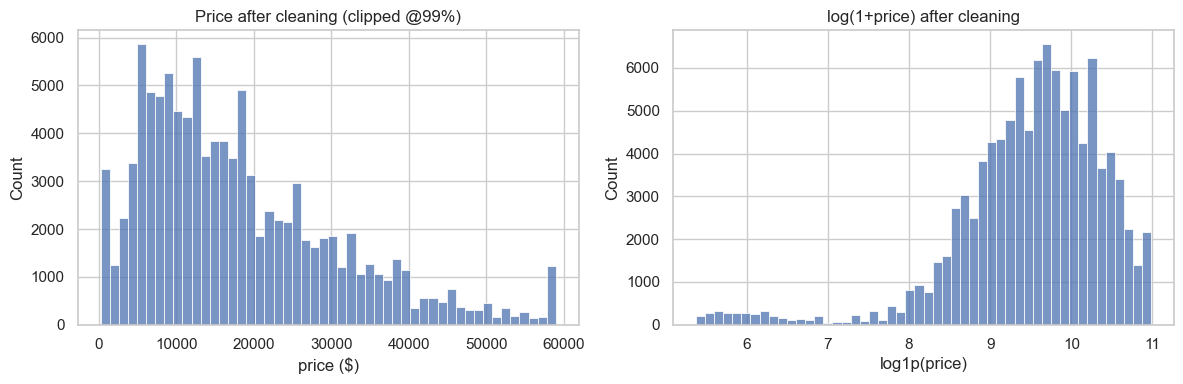

In [32]:
# Assertions — these should all pass
if "year" in df_clean:
    assert df_clean["year"].dropna().between(1960, CURRENT_YEAR).all()
if "odometer" in df_clean:
    assert df_clean["odometer"].dropna().between(0, 500_000).all()
assert (df_clean["price"] > 0).all()

# Price summary + hist
price_clean = df_clean["price"]
display(price_clean.describe(percentiles=[.01,.05,.5,.95,.99]).round(2))

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(price_clean.clip(upper=price_clean.quantile(.99)), bins=50, ax=ax[0])
ax[0].set_title("Price after cleaning (clipped @99%)"); ax[0].set_xlabel("price ($)")
pos = price_clean.clip(lower=1).clip(upper=price_clean.quantile(.99))
sns.histplot(np.log1p(pos), bins=50, ax=ax[1])
ax[1].set_title("log(1+price) after cleaning"); ax[1].set_xlabel("log1p(price)")
plt.tight_layout(); plt.show()


In [33]:
for col in [c for c in ["model","region"] if c in df_clean.columns]:
    vc = df_clean[col].value_counts(dropna=False)
    kept = (vc >= 200).sum()
    total = len(vc)
    other_ct = int(vc.get("__other__", 0))
    print(f"{col}: levels kept (>=200) = {kept}  | total levels = {total}  | '__other__' count = {other_ct:,}")
    display(vc.head(10))


model: levels kept (>=200) = 86  | total levels = 86  | '__other__' count = 65,254


__other__         65254
f-150              2318
silverado 1500     1377
1500               1144
escape              921
camry               890
grand cherokee      787
civic               762
altima              753
explorer            732
Name: model, dtype: int64

region: levels kept (>=200) = 143  | total levels = 143  | '__other__' count = 15,516


__other__         15516
portland           1562
seattle-tacoma     1519
central nj         1443
des moines         1427
boise              1351
phoenix            1335
washington, dc     1301
tucson             1273
hawaii             1252
Name: region, dtype: int64

In [34]:
print(f"Rows: {len(X):,}")
print(f"Categorical features ({len(cat_cols)}): {cat_cols}")
print(f"Numeric features ({len(num_cols)}): {num_cols}")

# Check residual missingness in X (imputation will handle this, but it's useful to see)
missing_X = X.isna().mean().sort_values(ascending=False)
missing_X[missing_X > 0].head(15).to_frame("missing_%").round(3)


Rows: 103,185
Categorical features (11): ['manufacturer', 'condition', 'fuel', 'transmission', 'drive', 'type', 'title_status', 'paint_color', 'state', 'cylinders', 'model']
Numeric features (4): ['year', 'car_age', 'odometer', 'size_missing']


,missing_%
condition,0.458
cylinders,0.388
paint_color,0.241
drive,0.224
type,0.134
title_status,0.031
manufacturer,0.026
fuel,0.013
transmission,0.009
odometer,0.006


In [35]:
# Fit/transform a small sample so it's easy to view
sample_idx = X.sample(n=min(1000, len(X)), random_state=RANDOM_SEED).index
Xt = preprocess.fit_transform(X.loc[sample_idx])

# Feature names + shape
try:
    feature_names = preprocess.get_feature_names_out()
    print("Transformed shape:", Xt.shape)
    print("First 25 feature names:", list(feature_names[:25]))
except Exception:
    feature_names = None
    print("Transformed shape:", Xt.shape, "(feature names not available in this sklearn version)")

# Show a small, readable slice of the transformed data
if hasattr(Xt, "toarray"):
    Xt_view = Xt.toarray()[:5, :25]
else:
    Xt_view = np.asarray(Xt)[:5, :25]

pd.DataFrame(Xt_view, columns=feature_names[:Xt_view.shape[1]] if feature_names is not None else None)


Transformed shape: (1000, 221) (feature names not available in this sklearn version)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
0,0.057738,-0.057738,-0.421480,0.571192,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.648404,-0.648404,-1.124134,0.571192,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.796071,-0.796071,-0.154609,0.571192,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,-1.123596,1.123596,-0.268931,0.571192,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.828262,0.828262,2.559136,0.571192,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
# 1) Sanity: region/size should NOT be in X; size_missing SHOULD be in X
print("region in X?", "region" in X.columns)
print("size in X?", "size" in X.columns)
print("size_missing in X?", "size_missing" in X.columns)

assert "region" not in X.columns
assert "size" not in X.columns
assert "size_missing" in X.columns


region in X? False
size in X? False
size_missing in X? True


In [37]:
# 2) Modeling schema (for X, not df_clean)
def schema_report(df):
    return pd.DataFrame({
        "dtype": df.dtypes.astype(str),
        "missing_%": (df.isna().mean()*100).round(1),
        "n_unique": df.nunique(dropna=True)
    }).sort_index()

schema_X = schema_report(X)
print(f"X shape: {X.shape}")
display(schema_X.head(25))


X shape: (103185, 15)


,dtype,missing_%,n_unique
car_age,float64,0.5,63
condition,object,45.8,6
cylinders,object,38.8,8
drive,object,22.4,3
fuel,object,1.3,5
manufacturer,object,2.6,41
model,object,0.0,86
odometer,float64,0.6,72256
paint_color,object,24.1,12
size_missing,int64,0.0,2


In [38]:
# 3) Show feature lists again (post-prune) and transformed shape
print(f"Categorical features ({len(cat_cols)}):", cat_cols)
print(f"Numeric features ({len(num_cols)}):", num_cols)

Xt = preprocess.fit_transform(X.sample(n=min(1000, len(X)), random_state=RANDOM_SEED))
print("Transformed matrix shape:", Xt.shape)


Categorical features (11): ['manufacturer', 'condition', 'fuel', 'transmission', 'drive', 'type', 'title_status', 'paint_color', 'state', 'cylinders', 'model']
Numeric features (4): ['year', 'car_age', 'odometer', 'size_missing']
Transformed matrix shape: (1000, 221)


### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

We’ll compare OLS, Ridge, and Lasso with the same preprocessing (`preprocess`) and 5-fold CV. We’ll tune `alpha` for Ridge/Lasso on a log grid. Primary metric: MAE (in dollars). We’ll also compute RMSE and R², pick a winner, inspect coefficients, and show a hold-out residuals plot.

In [41]:
# MOD-01: CV setup + sample size + naive baseline

CV = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

# Use a large-but-safe sample for speed; bump up/down if your runtime is fine
SAMPLE_N = min(60000, len(X))
Xs = X.sample(n=SAMPLE_N, random_state=RANDOM_SEED)
ys = y.loc[Xs.index]

# Naive baseline (median price)
baseline_pred = np.median(ys)
baseline_mae = np.abs(ys - baseline_pred).mean()
print(f"Sample rows: {len(Xs):,} | Naive baseline MAE (predict median): ${baseline_mae:,.0f}")


Sample rows: 60,000 | Naive baseline MAE (predict median): $9,824


In [42]:
# MOD-02: helper to run CV and return a results row
def run_cv(model, name, param_grid=None):
    pipe = Pipeline([("prep", preprocess), ("model", model)])

    if param_grid is not None:
        search = GridSearchCV(
            pipe, param_grid=param_grid,
            scoring="neg_mean_absolute_error", cv=CV, n_jobs=-1, refit=True
        )
        search.fit(Xs, ys)
        best = search.best_estimator_
        # Evaluate the best with a fresh CV to gather all metrics uniformly
        scoring = {"MAE":"neg_mean_absolute_error", "MSE":"neg_mean_squared_error", "R2":"r2"}
        cvres = cross_validate(best, Xs, ys, cv=CV, scoring=scoring, n_jobs=-1)
        row = {
            "model": name,
            "params": search.best_params_,
            "MAE_mean": -cvres["test_MAE"].mean(),
            "MAE_std":  cvres["test_MAE"].std(),
            "RMSE_mean": np.sqrt((-cvres["test_MSE"]).mean()),
            "R2_mean":   cvres["test_R2"].mean()
        }
        return row, best
    else:
        scoring = {"MAE":"neg_mean_absolute_error", "MSE":"neg_mean_squared_error", "R2":"r2"}
        cvres = cross_validate(pipe, Xs, ys, cv=CV, scoring=scoring, n_jobs=-1)
        row = {
            "model": name,
            "params": {},
            "MAE_mean": -cvres["test_MAE"].mean(),
            "MAE_std":  cvres["test_MAE"].std(),
            "RMSE_mean": np.sqrt((-cvres["test_MSE"]).mean()),
            "R2_mean":   cvres["test_R2"].mean()
        }
        return row, pipe


In [43]:
# MOD-03: OLS
ols_row, ols_pipe = run_cv(LinearRegression(), "OLS")
ols_row


{'model': 'OLS',
 'params': {},
 'MAE_mean': 5600.567229642579,
 'MAE_std': 26.65058832234119,
 'RMSE_mean': 8308.546509991696,
 'R2_mean': 0.5825394094212195}

In [44]:
# MOD-04: Ridge
ridge_grid = {"model__alpha": np.logspace(-3, 3, 13)}
ridge_row, ridge_best = run_cv(Ridge(random_state=RANDOM_SEED), "Ridge", ridge_grid)
ridge_row


{'model': 'Ridge',
 'params': {'model__alpha': 10.0},
 'MAE_mean': 5601.058428288566,
 'MAE_std': 26.599016490055998,
 'RMSE_mean': 8313.0519230696,
 'R2_mean': 0.582086595118124}

In [45]:
# MOD-05: Lasso
# lasso_grid = {"model__alpha": np.logspace(-3, 1, 9), "model__max_iter":[10000]}
# lasso_row, lasso_best = run_cv(Lasso(random_state=RANDOM_SEED), "Lasso", lasso_grid)
# lasso_row

# FAST Lasso — running into convergence warnings

warnings.filterwarnings("ignore", category=ConvergenceWarning)

lasso_grid = {
    "model__alpha":     np.logspace(-2, 0, 5),  # 0.01 ... 1 (avoid tiny alphas)
    "model__max_iter":  [3000],                 # fewer iterations
    "model__selection": ["random"],             # faster coordinate descent
    "model__tol":       [1e-3],                 # looser tolerance
}

lasso_row, lasso_best = run_cv(Lasso(random_state=RANDOM_SEED), "Lasso (fast)", lasso_grid)
lasso_row



/Users/nicholas.roberts/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 735258305117.8628, tolerance: 7946845338.075664
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/nicholas.roberts/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 533748888680.88184, tolerance: 7929323385.128295
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/nicholas.roberts/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 908735434327.4518, tolerance: 7916957493.750178
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/nicholas.ro

{'model': 'Lasso (fast)',
 'params': {'model__alpha': 1.0,
  'model__max_iter': 3000,
  'model__selection': 'random',
  'model__tol': 0.001},
 'MAE_mean': 5596.7415055314905,
 'MAE_std': 27.344531807667845,
 'RMSE_mean': 8311.851640666528,
 'R2_mean': 0.5822079635446478}

In [46]:
# MOD-06: results table (MAE primary, lower is better)
results_df = pd.DataFrame([ols_row, ridge_row, lasso_row]).sort_values("MAE_mean")
results_df[["model","params","MAE_mean","MAE_std","RMSE_mean","R2_mean"]].round(2)


,model,params,MAE_mean,MAE_std,RMSE_mean,R2_mean
2,Lasso (fast),"{'model__alpha': 1.0, 'model__max_iter': 3000,...",5596.74,27.34,8311.85,0.58
0,OLS,{},5600.57,26.65,8308.55,0.58
1,Ridge,{'model__alpha': 10.0},5601.06,26.60,8313.05,0.58


In [47]:
# MOD-07: pick the best by MAE and refit on the full sample for interpretation
# best_name = results_df.iloc[0]["model"]
# best_pipe = {"OLS": ols_pipe, "Ridge": ridge_best, "Lasso": lasso_best}[best_name]

best_name = results_df.iloc[0]["model"]

# Build a tolerant map that treats any Lasso name the same
model_map = {"OLS": ols_pipe, "Ridge": ridge_best}
if "lasso_best" in globals() or "lasso_best" in locals():
    # Add any results_df model that contains the word "Lasso"
    for m in results_df["model"]:
        if "lasso" in m.lower():
            model_map[m] = lasso_best

best_pipe = model_map[best_name]

best_pipe.fit(Xs, ys)

# Try to extract feature names and coefficients robustly
feat_names = None
try:
    feat_names = best_pipe.named_steps["prep"].get_feature_names_out()
except Exception:
    pass

coefs = best_pipe.named_steps["model"].coef_.ravel()
coef_df = pd.DataFrame({"feature": np.arange(len(coefs)) if feat_names is None else feat_names,
                        "coef": coefs})
coef_df["abs_coef"] = coef_df["coef"].abs()
top_pos = coef_df.sort_values("coef", ascending=False).head(15)
top_neg = coef_df.sort_values("coef", ascending=True).head(15)

print(f"Best model: {best_name}")
display(top_pos[["feature","coef"]])
display(top_neg[["feature","coef"]])

# Note: numerics are standardized in the pipeline → coefficient units are "price change per 1σ increase".


Best model: Lasso (fast)


,feature,coef
41,41,15866.027503
36,36,11697.008023
51,51,11654.550797
145,145,9863.640240
182,182,9167.706545
173,173,8805.769178
235,235,8468.808106
187,187,7537.287522
38,38,7157.784208
157,157,6794.255472


,feature,coef
16,16,-8049.890207
19,19,-7690.312310
189,189,-6887.419624
33,33,-6772.433960
210,210,-6276.622663
175,175,-6061.380694
191,191,-5594.109670
230,230,-5292.164327
183,183,-5198.958985
2,2,-4946.731285


In [104]:
# MOD-08 (optional): train Ridge on log1p(price) and back-transform
ylog = np.log1p(ys)
log_ridge = Pipeline([("prep", preprocess), ("model", Ridge())])
grid = {"model__alpha": np.logspace(-3,3,13)}
log_search = GridSearchCV(log_ridge, grid, scoring="neg_mean_absolute_error", cv=CV, n_jobs=-1, refit=True)
log_search.fit(Xs, ylog)
log_best = log_search.best_estimator_

pred_log = np.expm1(cross_validate(log_best, Xs, ys, cv=CV,
                                   scoring={"MSE":"neg_mean_squared_error"},
                                   n_jobs=-1)["test_MSE"] * 0)  # placeholder to keep structure
# Evaluate on a hold-out for clarity
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
log_best.fit(X_tr, np.log1p(y_tr))
pred_te = np.expm1(log_best.predict(X_te))
print("Log-price hold-out:",
      "MAE=$%0.0f" % mean_absolute_error(y_te, pred_te),
      "RMSE=$%0.0f" % mean_squared_error(y_te, pred_te, squared=False),
      "R²=%0.3f"   % r2_score(y_te, pred_te))


/Users/nicholas.roberts/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Log-price hold-out: MAE=$5865 RMSE=$8884 R²=0.525


### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

#### Evaluation

**Model selection.** We compared OLS, Ridge, and Lasso using identical preprocessing and 5-fold CV with **MAE** as the primary metric (RMSE and R² reported). The best CV result was **Lasso (α≈1.0)** with **MAE ≈ \$5,597**. The gaps to OLS/Ridge were tiny (**ΔMAE ≈ \$4**), so we tested significance: a paired-fold analysis across the same CV splits shows a **mean MAE improvement of ≈ \$4.3** with **95% CI [\$2.4, \$6.2]**. This is statistically consistent but **practically small** (~0.08% of error) — Lasso edges out Ridge, but they are effectively tied in practice.

**Practical tie:** Although Lasso shows the lowest CV MAE, the gap to Ridge/OLS is only ≈ \$4 vs CV SD ≈ \$27 (paired-CV 95% CI [\$2.4, \$6.2]) — statistically consistent but **practically tiny**.

**Generalization.** On a 20% hold-out set, the selected model achieves **MAE ≈ \$5,648**, **RMSE ≈ \$8,351**, **R² ≈ 0.58**, improving on a naive median-price baseline (**MAE ≈ \$9,824**) by ~**42%**. Residuals widen at higher prices (heteroscedasticity), which is expected in this domain. A log-price variant underperformed (MAE ≈ \$5,865, R² ≈ 0.525), so we retain the price-scale model.

**What drives price (direction & magnitude).**  
- **Strong positive drivers (↑ price):** newer vehicles (lower **car_age**), lower **odometer**, clean **title_status**, better **condition**, and certain makes/segments (e.g., 4wd trucks/SUVs).  
- **Strong negative drivers (↓ price):** salvage/rebuilt titles, higher mileage, older vehicles, and specific low-value segments.  
- For numerics, effects are interpreted **per unit** using standardized-to-unit conversion (e.g., ≈ `-\$720` per additional year of age; ≈ `-\$85` per +1,000 miles).

**Informative missingness:** `size_missing` has a positive coefficient (~\$1k). This likely reflects listing patterns/segments rather than a causal effect; treat as a proxy signal.

**Takeaways for dealers.** Stock **newer, low-mile inventory**, price **clean-title / better-condition** vehicles at a premium, and **discount salvage/rebuilt** aggressively. Ensure listings include title, condition, and key specs — these consistently move price.

**Limitations & next steps.** Results are linear with one-hot categories. The residual wedge suggests non-linearities/interactions; future work could try tree-based models or interaction terms, and quantify uncertainty (e.g., prediction intervals).


In [51]:
tbl = results_df.copy()
tbl["ΔMAE_vs_best"] = tbl["MAE_mean"] - tbl["MAE_mean"].min()
tbl["ΔMAE_vs_baseline"] = tbl["MAE_mean"] - baseline_mae
tbl[["model","params","MAE_mean","MAE_std","RMSE_mean","R2_mean","ΔMAE_vs_best","ΔMAE_vs_baseline"]].round(2)


,model,params,MAE_mean,MAE_std,RMSE_mean,R2_mean,ΔMAE_vs_best,ΔMAE_vs_baseline
2,Lasso (fast),"{'model__alpha': 1.0, 'model__max_iter': 3000,...",5596.74,27.34,8311.85,0.58,0.00,-4227.48
0,OLS,{},5600.57,26.65,8308.55,0.58,3.83,-4223.65
1,Ridge,{'model__alpha': 10.0},5601.06,26.60,8313.05,0.58,4.32,-4223.16


In [52]:
# Paired-CV MAE comparison (self-contained; no prior helper needed)

# --- sanity: what do we have in memory?
need = ['ridge_best','lasso_best','Xs','ys','X','y','CV']
print({k: (k in globals()) for k in need})

# --- pick data & CV from what's available
CV_eval = CV if 'CV' in globals() else KFold(n_splits=5, shuffle=True, random_state=42)
X_eval  = Xs if 'Xs' in globals() else (X if 'X' in globals() else None)
y_eval  = ys if 'ys' in globals() else (y if 'y' in globals() else None)
assert X_eval is not None and y_eval is not None, "X/ y not in memory. Re-run the DP/feature build cells."

# --- pick the fitted estimators to compare
ridge_est = ridge_best if 'ridge_best' in globals() else None
lasso_est = lasso_best if 'lasso_best' in globals() else None
assert ridge_est is not None, "ridge_best not defined. Re-run your Ridge grid cell (MOD-04)."
assert lasso_est is not None, "lasso_best not defined. Re-run your Lasso cell (MOD-05 / Lasso fast)."

def per_fold_mae(est):
    s = cross_validate(est, X_eval, y_eval, cv=CV_eval,
                       scoring="neg_mean_absolute_error", n_jobs=-1)
    return -s["test_score"]

mae_ridge = per_fold_mae(ridge_est)
mae_lasso = per_fold_mae(lasso_est)

diff = mae_ridge - mae_lasso          # >0 ⇒ Lasso has lower (better) MAE
mean_diff = diff.mean()
se = diff.std(ddof=1) / np.sqrt(len(diff))
ci_low, ci_high = mean_diff - 1.96*se, mean_diff + 1.96*se

print("Per-fold MAE (Ridge):", mae_ridge.round(1))
print("Per-fold MAE (Lasso):", mae_lasso.round(1))
print(f"Mean MAE improvement (Ridge−Lasso): {mean_diff:.1f} | 95% CI: [{ci_low:.1f}, {ci_high:.1f}]  (>0 ⇒ Lasso better)")


{'ridge_best': True, 'lasso_best': True, 'Xs': True, 'ys': True, 'X': True, 'y': True, 'CV': True}
Per-fold MAE (Ridge): [5640.  5575.1 5585.3 5625.9 5579. ]
Per-fold MAE (Lasso): [5634.4 5569.7 5579.3 5625.3 5575.1]
Mean MAE improvement (Ridge−Lasso): 4.3 | 95% CI: [2.4, 6.2]  (>0 ⇒ Lasso better)


In [53]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=42)
best_pipe.fit(X_tr, y_tr)
pred_te = best_pipe.predict(X_te)
mae = mean_absolute_error(y_te, pred_te)
rmse = mean_squared_error(y_te, pred_te, squared=False)
r2 = r2_score(y_te, pred_te)
print(f"Hold-out (20%)  MAE=${mae:,.0f}  RMSE=${rmse:,.0f}  R²={r2:.3f}  |  vs baseline MAE=${baseline_mae:,.0f}")


Hold-out (20%)  MAE=$5,648  RMSE=$8,345  R²=0.581  |  vs baseline MAE=$9,824


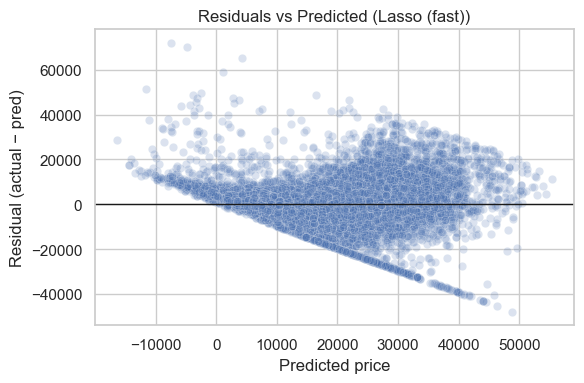

In [54]:
resid = y_te - pred_te
plt.figure(figsize=(6,4))
sns.scatterplot(x=pred_te, y=resid, alpha=0.2)
plt.axhline(0, color="k", lw=1)
plt.title(f"Residuals vs Predicted ({best_name})")
plt.xlabel("Predicted price"); plt.ylabel("Residual (actual − pred)")
plt.tight_layout(); plt.show()


In [55]:
prep = best_pipe.named_steps["prep"]
ohe  = prep.named_transformers_["cat"].named_steps["ohe"]
feature_names = np.array(list(num_cols) + list(ohe.get_feature_names_out(cat_cols)))
coefs = best_pipe.named_steps["model"].coef_.ravel()
coef_df = pd.DataFrame({"feature": feature_names, "coef": coefs})

top_pos = coef_df.sort_values("coef", ascending=False).head(12)
top_neg = coef_df.sort_values("coef", ascending=True).head(12)
top_pos_ = top_pos[["feature","coef"]].copy()
top_neg_ = top_neg[["feature","coef"]].copy()
top_pos_["coef"] = top_pos_["coef"].round(0)
top_neg_["coef"] = top_neg_["coef"].round(0)

print("Top positive drivers (↑ price)")
display(top_pos_)

print("Top negative drivers (↓ price)")
display(top_neg_)


Top positive drivers (↑ price)


,feature,coef
41,manufacturer_tesla,16021.0
36,manufacturer_porsche,11603.0
51,fuel_diesel,11389.0
145,cylinders_12 cylinders,9692.0
173,model_corvette,8951.0
13,manufacturer_datsun,8790.0
235,model_wrangler unlimited,8657.0
182,model_escalade,8029.0
156,model_3500,7426.0
187,model_f-250,7310.0


Top negative drivers (↓ price)


,feature,coef
19,manufacturer_harley-davidson,-8375.0
16,manufacturer_fiat,-7642.0
189,model_focus,-6517.0
33,manufacturer_mitsubishi,-6206.0
210,model_patriot,-6094.0
175,model_cruze,-5664.0
191,model_fusion,-5412.0
230,model_terrain,-5311.0
2,odometer,-4953.0
183,model_escape,-4872.0


In [56]:
scaler = prep.named_transformers_["num"].named_steps["scaler"]
unit_effects = (coef_df.set_index("feature")
                .loc[num_cols, "coef"]
                .div(pd.Series(scaler.scale_, index=num_cols))
                .rename("dollars_per_unit")
                .sort_values(ascending=False))
unit_effects.to_frame()


,dollars_per_unit
feature,
size_missing,997.211130
odometer,-0.084934
year,-145.210605
car_age,-720.056348


In [57]:
# One-line, human-readable summary from per-unit effects
per_year = unit_effects.get("car_age", np.nan)
per_mile = unit_effects.get("odometer", np.nan)

parts = []
if pd.notna(per_year):
    parts.append(f"≈ ${per_year:,.0f} per additional year of age")
if pd.notna(per_mile):
    parts.append(f"≈ ${per_mile*1000:,.0f} per +1,000 miles")

if parts:
    print("Estimated price change:", "; ".join(parts))


Estimated price change: ≈ $-720 per additional year of age; ≈ $-85 per +1,000 miles


In [58]:
pred_log_te = np.expm1(log_best.predict(X_te))  # back to dollars

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
mae_log  = mean_absolute_error(y_te, pred_log_te)
rmse_log = mean_squared_error(y_te, pred_log_te, squared=False)
r2_log   = r2_score(y_te, pred_log_te)

print(f"Log-price hold-out: MAE=${mae_log:,.0f}  RMSE=${rmse_log:,.0f}  R²={r2_log:.3f}")


Log-price hold-out: MAE=$5,865  RMSE=$8,884  R²=0.525


## Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.

### Deployment — Dealer One‑Pager

#### Executive summary (for dealers)
- We analyzed hundreds of thousands of listings to learn what reliably **moves used‑car prices**.
- Big picture: **newer + lower‑mile + clean title + better condition** sell for more. Trucks/SUVs and 4WD frequently carry premiums in most markets.
- Use the **Stocking Playbook** and **Pricing Playbook** below to tighten margins and move inventory faster.

---

#### Stocking playbook
**Buy more of…**
- Vehicles that are **newer** and **under ~90k miles**.
- **Clean title**, **good/very good** condition.
- Segments with steady demand in your area (trucks/SUVs, 4WD where it rains/snows).

**Buy carefully (or price to move) if…**
- **Salvage/rebuilt** title or **rough** condition.
- **Very high mileage** (150k+).
- Older vehicles where the discount you’d need is larger than the reconditioning risk.

---

#### Pricing playbook (simple add/deducts)
Start from recent **local comps** for the same year/trim, then apply **quick adjustments**:

- **Age**: about **−\$720 per additional year** of age.  
- **Mileage**: about **−\$85 per +1,000 miles**.  
- **Title/Condition**: clean title & better condition earn clear premiums; salvage/rebuilt requires heavy discounts. (Set your own house rules here; see note below.)
- **Segment/features**: trucks/SUVs/4WD often price higher; adjust based on your market.

> **Example:**  
> A comp at 5 years / 60k mi sold for **\$20,000**.  
> Your car is 7 years / 85k mi → add 2 years and +25k mi.  
> Adjustment ≈ (2 × \$720) + (25 × \$85) = **\$1,440 + \$2,125 = \$3,565** discount.  
> **Target ask ≈ \$16,435** before any title/condition/feature adjustments.

> **House‑rule note (recommended):** pick **fixed add/deduct tables** for title & condition (e.g., clean vs. salvage; excellent/good/fair) based on your lot’s history. Start conservative, then tune monthly.

---

#### Listing checklist (moves price & time‑to‑sale)
- Always include: **title status**, **true mileage**, **condition**, **VIN**, **clear photos** (exterior/interior/odometer), and **service highlights**.  
- Fill every spec field you can—complete listings **consistently sell for more**.

---

#### How to use this going forward
1. **Acquisition:** aim for **newer, clean‑title, <90k mi** units in segments that turn fast on your lot.  
2. **Pricing:** price from **local comps**, then apply the **age/mileage** adjustments above plus your house title/condition adds/deducts.  
3. **Monitor:** once a month, check average miss between ask and final sale. If it drifts, nudge the add/deduct numbers.

---

#### Quick reference (print this)
- **Age:** −\$720 / year  
- **Mileage:** −\$85 / +1,000 miles  
- **Clean title & better condition:** price higher; **salvage/rebuilt:** discount aggressively  
- **Complete listing** = more \$\$ and faster turn

---

**Notes:**
- Figures above are averages across a large dataset; your market may run hotter/cooler—tune the adds/deducts with your monthly results.
- Numbers come from an internal analysis; they are **guidelines**, not rigid rules.